In [1]:
import cv2
import numpy as np
import random as rng
import matplotlib.pyplot as plt
import sklearn.preprocessing  as pre
import math 
import torch
from numpy import linalg 
import random
import math
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def boundingBoxes(frame_diff,contours,show=False):
    
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    
    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 5, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])
    
    drawing = np.zeros((frame_diff.shape[0], frame_diff.shape[1], 3), dtype=np.uint8)
    
    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv2.drawContours(drawing, contours_poly, i, color)
        cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
          (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
    
    if show:
        display=resize(drawing)
        cv2.imshow('all boxes', display)

    return frame_diff, boundRect
        
def resize(frame):
    scale_percent = 60 # percent of original size
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    return resized

def drawContour(mask,kernelsize=15):
    
    kernel6 = np.ones((kernelsize,kernelsize), np.uint8)
    dil = cv2.dilate(mask, kernel6, iterations=1)
    contours, _ = cv2.findContours(dil, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    return dil,contours

def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    
    return new_img

def correlation_coefficient(patch1, patch2):
    product = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stds = patch1.std() * patch2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product
    


(32, 32, 3)
(32, 32, 3)


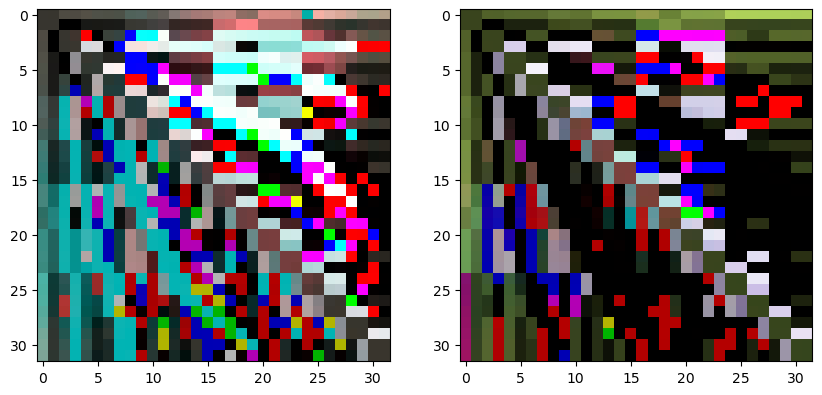

[[0.32941176 0.29542484 0.04705882]
 [0.32941176 0.29542484 0.04575163]]


In [3]:
def middle(box):
    return [box[0]+(box[2]//2),box[1]+(box[3]//2)]

def decomp_row(row,size):
    row=row/math.sqrt(2)
    while size>1:
        size=size//2
        for i in range(size):
            A=row[2*i]
            B=row[2*i+1]
            row[i],row[size+i]=(A+B)/math.sqrt(2),(A-B)/math.sqrt(2)
    return row
                       
def decomp_2D(img,size):
    for i in range(size):
        img[i,:]=decomp_row(img[i,:],i)
    return img
        
def decomp_RGB(img,size):
    for i in range(3):
        img[:,:,i]=np.transpose(decomp_2D(img[:,:,i],size))
        img[:,:,i]=np.transpose(decomp_2D(img[:,:,i],size))
    return img

def Wavelet(img):
    img= cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    
    n=min(img.shape[0],img.shape[1])
    
    size = 1
    while size < n: size *=2
    size//=2
    
    middle_x=img.shape[0]//2
    middle_y=img.shape[1]//2
    
    resized=img[middle_x-(size//2):middle_x+(size//2),middle_y-(size//2):middle_y+(size//2),:]
    
    res=decomp_RGB(resized,size)
    
    return res


fig = plt.figure(figsize=(10, 7))

template_test = cv2.imread('template/templateRGB_Black.png')
waveletT=Wavelet(template_test)
print(waveletT.shape)
fig.add_subplot(1,2,1)
plt.imshow(waveletT)

template_test = cv2.imread('template/templateGoal.png')
wavelet=Wavelet(template_test)
print(wavelet.shape)
fig.add_subplot(1,2,2)
plt.imshow(wavelet)

plt.show()

print(sum(waveletT[0:2,0:2,:]-wavelet[0:2,0:2,:])/(3*255))


In [4]:

template = cv2.imread('template/templateRGB_Black.png')
template_HSV= cv2.cvtColor(template,cv2.COLOR_BGR2HSV)

wave_temp=Wavelet(template)
size_min=wave_temp.shape[0]//2
size_max=wave_temp.shape[0]*3

templateB = cv2.imread('template/templateGoal.png')
wave_temp2 = Wavelet(templateB)

def checkBoxes(frame_diff, boundingBoxes ,show=True,coeff=150):
    
    maxBox=None
    totH=0    
    for box in boundingBoxes:

        if box[3]>size_min and box[3]<size_max and box[2]>size_min and box[2]<size_max and box[2]/box[3]<100 and box[2]/box[3]>0.001:

            box_cp = frame_diff[box[1]:(box[1]+box[3]),box[0]:(box[0]+box[2]),:]
            wave_box=Wavelet(box_cp)

            diff1=cv2.absdiff(wave_temp[0:2,0:2,:],wave_box[0:2,0:2,:])#cv2.absdiff(wave_temp[0,0,:],wave_box[0,0,:])+cv2.absdiff(wave_temp[1,1,:],wave_box[1,1,:])
            diff2=cv2.absdiff(wave_temp2[0:2,0:2,:],wave_box[0:2,0:2,:])#cv2.absdiff(wave_temp2[0,0,:],wave_box[0,0,:])+cv2.absdiff(wave_temp2[1,1,:],wave_box[1,1,:])
            diff=min(np.sum(diff1),np.sum(diff2))
        
            diff=np.sum(diff)
            #diff=np.sum(diff,axis=0)
            
            diff_weight=( diff/3 )
            
            if diff_weight is not None and coeff>diff_weight:
                coeff=diff_weight
                maxBox=box

    if maxBox is None:
        return None,None
    
    print(coeff)
    if show:
        box_cp= frame_diff[maxBox[1]:(maxBox[1]+maxBox[3]),maxBox[0]:(maxBox[0]+maxBox[2]),:]   
        cv2.rectangle(frame_diff, (int(box[0]), int(box[1])),(int(box[0]+box[2]), int(box[1]+box[3])), (255,255,255), 2)        
        display = resize(frame_diff)
        cv2.imshow('rec',display)
    
    return frame_diff,maxBox

"""

    M=template_HSV.shape[0]//2
    middle_pts=template_HSV[M,M,:]

    frameHSV= cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    blurred = cv2.GaussianBlur(frameHSV, (11, 11), 0)

    lower_white = np.array([middle_pts[0]-50,0,160])
    upper_white = np.array([middle_pts[0]+50,70,255])
    
    lower_black = np.array([middle_pts[0]-50,0,0])
    upper_black = np.array([middle_pts[0]+50,70,160])
    
"""


def selectWhite(frame,show=False):

    frameHSV= cv2.cvtColor(frame,cv2.COLOR_BGR2HLS)
    blurred = cv2.GaussianBlur(frameHSV, (11, 11), 0)

    lower_white = np.array([10,170,0])
    upper_white = np.array([255,255,255])
    
    lower_black = np.array([10,0,0])
    upper_black = np.array([255,50,255])

    maskW = cv2.inRange(blurred, lower_white, upper_white)
    maskB = cv2.inRange(blurred, lower_black, upper_black)

    mask = cv2.bitwise_or(maskW,maskB)
    mask = cv2.erode(mask, None, iterations=1)
    mask = cv2.dilate(mask, None, iterations=4)

    if show:
        display=resize(mask)
        cv2.imshow('select white', display)

    return mask

In [5]:

def distanceDroite3D(droite,pts):
    
    droiteD=droite[0]-droite[1]
    droiteD=np.int64(droiteD)

    normeDroite=math.sqrt(droiteD[0]**2 + droiteD[1]**2 + droiteD[2]**2)
    AP=pts-droite[0]
    
    cross=np.cross(AP,droiteD)
    cross=np.int64(cross)

    normecross=math.sqrt(cross[0]**2 + cross[1]**2 + cross[2]**2)

    if normeDroite<0.000000000001:
        return 2000
    
    return normecross/normeDroite


def distanceDroite(droite,pts):
    a=(droite[1][1]-droite[0][1])/(droite[1][0]-droite[0][0])
    b=droite[1][1]-a*droite[1][0]
    return abs(a*pts[0]-pts[1]+b)/math.sqrt(a**2+1)

def distanceCoude(droite,pts,type):

    a0=droite[0][0]
    a1=droite[0][1]

    b0=droite[1][0]
    b1=droite[1][1]

    m0=pts[0]
    m1=pts[1]

    X= ( (b0-a0)*(m0-b0)+(b1-a1)*(m1-b1) )/( (b0-a0)**2+(b1-a1)**2 )

    x=b0+(b0-a0)*X
    y=b1+(b1-a1)*X

    D=1000
    coeff=50

    if type==1 and ((a0<b0 and x<b0+coeff) or (a0>b0 and x>b0-coeff)) and ((a1<b1 and y<b1+coeff) or (a1>b1 and y>b1-coeff)):
        D= distanceDroite(droite,pts)

    if type==2 and ((a0<b0 and x>b0-coeff) or (a0>b0 and x<b0+coeff)) and ((a1<b1 and y>b1-coeff) or (a1>b1 and y<b1+coeff)):
        D= distanceDroite(droite,pts)


    #if ( (a0>b0 and x>b0-coeff and x<a0+coeff) or (a0<b0 and x<b0+coeff and x>a0-coeff) ) and ( (a1>b1 and x>b1-coeff and x<a1+coeff) or (a1<b1 and x<b1+coeff and x>a1-coeff) ) :
        #D= distanceDroite(droite,pts)

    return D



def RANSAC(pts,N=500,distanceMin=20,lastPosition=None,D3=False):
    best_score=0
    best_model=None
    best_droite=None
    
    for k in range(N):
        score=0
        
        start=random.randint(0, pts.shape[0]-1)
        end=random.randint(pts.shape[0]//2, pts.shape[0]-1)
        
        droite=[pts[start][:],pts[end][:]]
        
        model=np.array((pts[start],pts[end]))

        firstLoop=True
        for P in pts:
            if D3:
                D=distanceDroite3D(droite,P)
            else:
                D=distanceDroite(droite,P)

            """if firstLoop and lastPosition is not None:
                Dlast=np.linalg.norm(P[:2]-lastPosition[:2])
                if firstLoop  and D<distanceMin and Dlast>distanceMin*15:
                    break"""

            if D<distanceMin:
                """if firstLoop:
                    score+=2"""
                score+=1
                model=np.vstack((model,P))
                
            firstLoop=False

        if score>pts.shape[0]//2 and score>best_score :
            best_droite=droite
            best_model=model
            best_score=score

        model=None
        
    if best_model is None:
        return None,None
    else:
        return best_model[2:],best_droite
    
def RANSACcoude(pts,N=500,distanceMin=20,lastPosition=None):
    best_score=0
    best_model=None
    best_droite=None

    for k in range(N):
        score=0
        branche1=0
        branche2=0
        
        start=random.randint(0, pts.shape[0]//2)
        end=random.randint(pts.shape[0]//2, pts.shape[0]-1)
        middle=random.randint(start, end)
        
        droite1=[pts[start][:],pts[middle][:]]
        droite2=[pts[middle][:],pts[end][:]]
        
        model=np.array((pts[start],pts[end]))
        
        for P in pts:
            Dbr1=distanceDroite3D(droite1,P)
            Dbr2=distanceDroite3D(droite2,P)
            D=min(Dbr1,Dbr2)

            if Dbr1==D:
                branche1+=1
            else:
                branche2+=1


            if D<distanceMin:
                score+=1
                model=np.vstack((model,P))
                    
            firstLoop=False
        if score>pts.shape[0]//2 and score>best_score  :
            best_droite=[droite1,droite2]
            best_model=model
            best_score=score

        model=None
        
    if best_model is None:
        return None,None
    else:
        return best_model[2:],best_droite

In [6]:
def plotLines(lines,lines2=None,frame=None):

    for index, item in enumerate(lines): 
        if index == len(lines) -1:
            break
        cv2.line(frame, item[:2], lines[index + 1][:2], [10, 10, 255], 3)  
        
    for index, item in enumerate(lines2): 
        if index == len(lines2) -1:
            break
        cv2.line(frame, item[:2], lines2[index + 1][:2], [255, 10, 10], 2)  

def doRansac( position, frame,distMin=20,lastPosition=None,D3=False ):
    
    model,droite=RANSACcoude(position,N=position.shape[0]**3,distanceMin=distMin)

    
    if model is not None:
        cv2.line(frame, droite[0][1][:2], droite[0][0][:2], [0, 0, 0], 5) 
        cv2.line(frame, droite[1][1][:2], droite[1][0][:2], [0, 0, 0], 5) 
        #cv2.line(frame, droite[1][:2], droite[0][:2], [0, 0, 0], 5) 

        key = cv2.waitKey(0)
        

    return model,droite

In [7]:
%matplotlib inline
%matplotlib qt

In [8]:

cap = cv2.VideoCapture('video_record/1310.mp4')

#template = cv2.imread('template/templateRGB_black.png')
#template = cv2.imread('template/templateRGB.png')

#print(template.dtype,template.shape)
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")


# previous frame for subtraction
frame1=None
frame0=None

YUV=None
# for showing after the loop
frame_end=None

first_frame=None
white_border=None
first=False


#3D points
position=[[0,0,0]]
#pts after ransac
corrected=[[0,0,0]]
corrected2=[[0,0,0]]
lastcorrected=0
firstLoop=True
lastLen=0
allmodel=[ [ [[0,0,0],[0,0,0]],[[0,0,0],[0,0,0]] ] ]
#allmodel=[[[0,0,0],[0,0,0]]]
model=None
lastPosition=None

static=False
static_box=None

# index for the 3 dimension of frame = time of the frame
idx=0
size_slice=15

  
#Read until video is completed
while(cap.isOpened()):
    
    # Capture frame-by-frame
    ret, frame_og= cap.read()
    
    if ret == True:
        model=None
        frame_og_crop=frame_og[:,:,:].copy()
        frame_end = frame_og_crop.copy()

        if first_frame is None:
            frame0=frame_og_crop.copy()
            frame1=frame_og_crop.copy()
            
            first_frame = frame_og_crop.copy()
            white_border=selectWhite(first_frame)

            white_border=cv2.bitwise_not(white_border)

            display=resize(white_border)
            cv2.imshow('not border', display)

    
        frame0 = frame1.copy()
        frame1 = frame_og_crop.copy()


        maskW1=selectWhite(frame1)
        maskW0=selectWhite(frame0)

        maskW=cv2.bitwise_or(maskW1, maskW0, mask = None)
        maskW=cv2.bitwise_and(maskW,white_border, mask=None)
        maskW = cv2.erode(maskW, None, iterations=6)
        maskW = cv2.dilate(maskW, None, iterations=10)
        
        
        frame_white=cv2.bitwise_and(frame_og_crop.copy(),frame_og_crop.copy(), mask=maskW)
        display=resize(maskW)
        cv2.imshow('white select 2 frames', display)
        
        frame1RGB=cv2.cvtColor(frame1,cv2.COLOR_YUV2BGR)
        
        #draw contour on frame
        dil,contours=drawContour(maskW)
        #hide non-contoured area
        masked1=cv2.bitwise_and(frame1RGB, frame1RGB, mask=dil)
        #detection
        _,boundRect=boundingBoxes(masked1,contours)

        _, box = checkBoxes(frame_og_crop.copy(),boundRect,show=False,coeff=100)
        
        # 3D points
        if box is not None:
            pts=middle(box)
            # if same point, don't take it
            if not np.array_equal(pts, position[-1][:2]) and ((pts[0]-position[-1][0])**2+(pts[1]-position[-1][1])**2)>100:
                position=np.append(position,[[pts[0],pts[1],idx]],axis=0) 
                idx+=50

            cv2.rectangle(frame_og_crop, (int(box[0]), int(box[1])),(int(box[0]+box[2]), int(box[1]+box[3])), (255,255,255), 2) 

            display=resize(frame_og_crop)
            cv2.imshow('detection', display)


        #Ransac
        Len=len(position)
        if Len%size_slice==0 and lastLen!=Len:
            if firstLoop:
                position=position[1:]

            sliced=position[(Len-size_slice):]

            if model is not None:
                sliced=np.concatenate((corrected[len(corrected)-2:],sliced))

            #model,droite=doRansac(sliced,frame_og_crop,distMin=25,D3=True)
            model,droite=doRansac(sliced,frame_og_crop,distMin=15,D3=True)
            lastLen=Len

            if model is not None:
                corrected=np.concatenate((corrected,model))
                allmodel=np.append(allmodel,[droite],axis=0)

                if firstLoop:
                    position=position[1:]
                    corrected=corrected[1:]
        
        
        k=lastcorrected
        lenCorrect=len(corrected)
        
        while k < (lenCorrect-5) :
            diff1=cv2.absdiff(corrected[k],corrected[k+1])
            diff2=cv2.absdiff(corrected[k],corrected[k+5])
            corrected2=np.append(corrected2,[corrected[k]],axis=0)

            if diff1[0]+diff1[1]*1 < (diff2[0]+diff2[1]):
                k+=1
            else:
                k+=4
        if firstLoop and model is not None:
            corrected2=corrected2[1:]
            firstLoop=False
        if lenCorrect>5:
            lastcorrected = lenCorrect-5


        #plot
        for index, item in enumerate(position): 
            cv2.circle(frame_og_crop, item[:2], 2, [20, 255, 20], 5)

        plotLines(corrected,lines2=corrected2,frame=frame_og_crop)

        display=resize(frame_og_crop)
        cv2.imshow('detection', display)
    
        #press key to go the next frame or Q to exit
        key = cv2.waitKey(0)
        
        if key == ord('q') or key == ord('Q'):
            break
        elif key == ord('f') or key == ord('F'):
            first=True
        elif key == ord('s') or key == ord('S'):
            cv2.imwrite("image.png", frame_og)
            break
        else:
            continue
            
  # Break the loop
    else: 
        break
    

allmodel=allmodel[1:]



15.0
13.666666666666666
17.666666666666668
17.0
19.333333333333332
19.0
18.333333333333332
18.0
18.333333333333332
18.333333333333332
32.666666666666664
36.333333333333336
31.333333333333332
39.666666666666664
35.666666666666664
19.666666666666668
19.666666666666668
39.333333333333336
39.333333333333336
39.333333333333336
38.333333333333336
38.0
39.333333333333336
39.0
38.0
38.333333333333336
39.333333333333336
21.666666666666668
12.333333333333334
36.0
36.0
37.333333333333336
36.333333333333336
39.0
37.666666666666664
19.333333333333332
18.333333333333332
19.333333333333332
17.0
29.333333333333332
26.333333333333332
25.0
38.666666666666664
32.0
23.0
26.0
26.0
21.0
20.333333333333332
18.333333333333332
15.666666666666666
22.0
22.0
26.666666666666668
21.333333333333332
22.333333333333332
21.0
21.333333333333332
20.666666666666668
20.0
20.666666666666668
28.666666666666668
22.333333333333332
38.0
24.0
22.666666666666668
19.666666666666668
37.0
37.333333333333336
1.6666666666666667
3.3333

In [9]:

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.grid()

ax.plot3D(corrected[:,1],corrected[:,0],corrected[:,2],'r')
ax.scatter(position[:,1],position[:,0],position[:,2],marker="+")

for item in allmodel:
     start_pts=item[0][0]
     middle_pts=item[0][1]
     end_pts=item[1][1]
     
     ax.scatter(middle_pts[1],middle_pts[0],middle_pts[2],color='k')
     ax.scatter(end_pts[1],end_pts[0],end_pts[2],color='g')
     ax.scatter(start_pts[1],start_pts[0],start_pts[2],color='g')
     
     ax.plot([start_pts[1], middle_pts[1]], [start_pts[0], middle_pts[0]], zs=[start_pts[2], middle_pts[2]],color='k')
     ax.plot([end_pts[1], middle_pts[1]], [end_pts[0], middle_pts[0]], zs=[end_pts[2], middle_pts[2]],color='k')


ax.set_ylabel('x', labelpad=20)
ax.set_ylim(0, 1500)
ax.set_xlabel('y', labelpad=20)
ax.set_xlim(0, 1500)
ax.set_zlabel('t', labelpad=20)
#ax.set_zlim(0, 100)

fig = plt.figure(figsize = (8,8))

plt.plot(corrected[:,2],corrected[:,1],'g')
plt.plot(corrected[:,2],corrected[:,0],'r')
plt.plot(corrected[:,2],corrected[:,1],'g+')
plt.plot(corrected[:,2],corrected[:,0],'r+')

fig = plt.figure(figsize = (8,8))

plt.plot(corrected2[:,2],corrected2[:,1],'k')
plt.plot(corrected2[:,2],corrected2[:,0],'b')

plt.show()

plotLines(corrected,corrected2,frame_og_crop)

key = cv2.waitKey(0)
#When everything done, release the video capture object
cap.release()  
# Closes all the frames
cv2.destroyAllWindows()

In [10]:

template = cv2.imread('template/templateGoal.png')
template_HSV= cv2.cvtColor(template,cv2.COLOR_BGR2HSV)
M=template_HSV.shape[0]//2
middle_pts=template_HSV[M,M,:]
print(middle_pts)

wave_temp2 = Wavelet(templateB)


[ 90   7 255]
